In [1]:
import pandas as pd
from constants import *
from helpers import normalise_number_data, normalise_word_data
import numpy as np
from sklearn import preprocessing

In [2]:
google_products = pd.read_csv(GOOGLE_SMALL_PATH)
amazon_products = pd.read_csv(AMAZON_SMALL_PATH)

In [3]:
google_products['price'] = normalise_number_data(google_products['price'])
amazon_products['price'] = normalise_number_data(amazon_products['price'])

In [4]:
google_products[['name']]
google_word_columns = ['name', 'description', 'manufacturer']
amazon_word_columns = ['title', 'description', 'manufacturer']

In [5]:
google_products[google_word_columns] = normalise_word_data(google_products[google_word_columns].astype(str))
amazon_products[amazon_word_columns] = normalise_word_data(amazon_products[amazon_word_columns].astype(str))

In [6]:
yeast_data = pd.read_csv(YEAST_PATH)

In [7]:
yeast_data['Class'] = yeast_data.Class.replace(to_replace=yeast_data.Class.unique(), value=[0, 1])

In [8]:
from sklearn.impute import SimpleImputer    

In [9]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yeast_data.drop(['Class', 'Sample', 'pox'], axis=1), yeast_data['Class'], test_size=0.33)
X_train_mean = pd.DataFrame(mean_imputer.fit_transform(X_train))
X_train_median = pd.DataFrame(median_imputer.fit_transform(X_train))


X_test_mean = pd.DataFrame(mean_imputer.fit_transform(X_test))
X_test_median = pd.DataFrame(median_imputer.fit_transform(X_test))

#Y = yeast_data['Class']

In [11]:
X_train_mean.describe()

,0,1,2,3,4,5,6
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.497558,0.501801,0.506640,0.264573,0.506751,0.505296,0.282668
std,0.132140,0.120146,0.237389,0.159379,0.103859,0.182649,0.170631
min,0.110000,0.140000,0.210000,0.000000,0.500000,0.130000,0.010000
25%,0.410000,0.430000,0.460000,0.170000,0.500000,0.480000,0.220000
50%,0.497558,0.500000,0.506640,0.230000,0.500000,0.510000,0.220000
75%,0.570000,0.570000,0.550000,0.300000,0.500000,0.530000,0.300000
max,0.940000,0.940000,7.501819,3.000728,3.500849,6.001456,4.501092


In [12]:
X_train_median.describe()

,0,1,2,3,4,5,6
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.496127,0.501751,0.506903,0.260896,0.506540,0.505585,0.279579
std,0.132227,0.120147,0.237390,0.159850,0.103866,0.182652,0.171170
min,0.110000,0.140000,0.210000,0.000000,0.500000,0.130000,0.010000
25%,0.410000,0.430000,0.460000,0.170000,0.500000,0.480000,0.220000
50%,0.480000,0.500000,0.510000,0.220000,0.500000,0.510000,0.220000
75%,0.570000,0.570000,0.550000,0.300000,0.500000,0.530000,0.300000
max,0.940000,0.940000,7.501819,3.000728,3.500849,6.001456,4.501092


In [13]:
from sklearn.preprocessing import StandardScaler, normalize
stdscl = StandardScaler(with_mean=True, with_std=True)

In [14]:
X_train_std = pd.DataFrame(stdscl.fit_transform(X_train_median))
X_train_norm = pd.DataFrame(normalize(X_train_median))

X_test_std = pd.DataFrame(stdscl.fit_transform(X_test_median))
X_test_norm = pd.DataFrame(normalize(X_test_median))

In [15]:
X_train_std.describe()

,0,1,2,3,4,5,6
count,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02,9.940000e+02
mean,3.574159e-16,1.072248e-16,2.627007e-16,-4.288990e-17,-1.715596e-16,-4.306861e-16,1.831756e-17
std,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00,1.000503e+00
min,-2.921651e+00,-3.012425e+00,-1.251326e+00,-1.632948e+00,-6.299845e-02,-2.057320e+00,-1.575711e+00
25%,-6.516833e-01,-5.974920e-01,-1.976780e-01,-5.689185e-01,-6.299845e-02,-1.401453e-01,-3.482421e-01
50%,-1.220241e-01,-1.457706e-02,1.305158e-02,-2.559686e-01,-6.299845e-02,2.418397e-02,-3.482421e-01
75%,5.589663e-01,5.683379e-01,1.816352e-01,2.447512e-01,-6.299845e-02,1.337368e-01,1.193651e-01
max,3.358593e+00,3.649460e+00,2.948071e+01,1.714860e+01,2.884316e+01,3.010441e+01,2.467512e+01


In [16]:
X_train_norm.describe()

,0,1,2,3,4,5,6
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,0.406409,0.412393,0.416543,0.211238,0.419828,0.417001,0.228968
std,0.085816,0.081304,0.079611,0.100550,0.050607,0.059817,0.086859
min,0.052470,0.044185,0.095172,0.000000,0.066121,0.046285,0.006944
25%,0.351705,0.364275,0.369408,0.143810,0.394490,0.388574,0.180595
50%,0.406577,0.416478,0.424784,0.186430,0.420176,0.422068,0.200161
75%,0.459825,0.461760,0.466840,0.252348,0.445365,0.451369,0.252540
max,0.647807,0.696144,0.992055,0.949385,0.966781,0.984776,0.971999


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [18]:
knn_10 = KNeighborsClassifier(n_neighbors=10)
knn = KNeighborsClassifier(n_neighbors=5)
dtc = DecisionTreeClassifier()

In [19]:
X_train = X_train_norm
X_test = X_test_norm

In [20]:
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_train)
y_pred_knn_test = knn.predict(X_test)

knn_10.fit(X_train, y_train)
y_pred_knn_10 = knn_10.predict(X_train)
y_pred_knn_10_test = knn_10.predict(X_test)

In [21]:
from sklearn.metrics import precision_score
score_train_knn = precision_score(y_train, y_pred_knn)
score_test_knn = precision_score(y_test, y_pred_knn_test)

In [22]:
score_train_knn_10 = precision_score(y_train, y_pred_knn_10)
score_test_knn_10 = precision_score(y_test, y_pred_knn_10_test)

In [23]:
print(score_train_knn)
print(score_test_knn)

print(score_train_knn_10)
print(score_test_knn_10)

0.679324894514768
0.5034013605442177
0.7100591715976331
0.5108695652173914


In [24]:
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=5, encode='onehot')


X_binned = enc.fit_transform(X_train)
X_binned_test = enc.fit_transform(X_test)

In [25]:
dtc.fit(X_binned, y_train)

Y_pred_dtc = dtc.predict(X_binned)
Y_pred_test_dtc = dtc.predict(X_binned_test)

In [26]:
score_dtc = precision_score(Y_pred_dtc, y_train)
score_test_dtc = precision_score(Y_pred_test_dtc, y_test)

In [27]:
print(score_dtc)
print(score_test_dtc)

0.9419795221843004
0.4176470588235294


In [28]:
def pair_interaction_featurize(X):
    features_multiplied = pd.DataFrame()
    for i in X:
        for j in X:
            if int(j) > int(i):
                col1 = pd.Series(X[i])
                col2 = pd.Series(X[j])
                col1 = col1.mul(col2)
                features_multiplied[int(str(i) + str(j))] = col1 
    generated_features = pd.concat([features_multiplied, X], axis=1)
    return features_multiplied

         
X_train_interaction_pair = pair_interaction_featurize(X_train)
X_test_intraction_pair = pair_interaction_featurize(X_test)


# X_norm = X_norm.sample(frac=1).reset_index(drop=True)
# X_train_with_labels_new_features = features_multiplied[0:1000]
# X_train = X_train_with_labels.drop(['label', 6, 0], axis=1)



In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state = 0).fit(X_train)
Y_pred_kmeans = kmeans.predict(X_train)
kmeans.score(X_train)
print(kmeans.inertia_)
#score_kmeans = precision_score(Y_pred_kmeans, y_train)
# score_kmeans
# Y_pred_kmeans


22.968843716036808


In [36]:
from sklearn.feature_selection import mutual_info_classif

enc_mi = KBinsDiscretizer(n_bins=15, encode='onehot')
X_binned_mi = enc_mi.fit_transform(X_train_interaction_pair)
X_binned_test_mi = enc_mi.fit_transform(X_test_intraction_pair)

mutual_info_classifier = mutual_info_classif(X_binned_mi, y_train)


entropy_with_index = sorted([(index, el) for index, el in zip(mutual_info_classifier, X_train_interaction_pair.columns)], key=lambda x: x[0], reverse=True)
entropy_with_index


[(0.020094584424129824, 26),
 (0.012134092246540693, 35),
 (0.003954719458216301, 56),
 (0.0032933706281843694, 34),
 (0.0023815413489344725, 45),
 (0.0023815413489344725, 46),
 (0.002112509971280846, 14),
 (0.0017601532726104277, 36),
 (0.0014421197328533114, 16),
 (0.0012403575593682992, 25),
 (0.0010243048172150632, 6),
 (0.000816986854942893, 23),
 (0.0006759780812583688, 1),
 (0.0004791396849720825, 5),
 (0.0002488909789969268, 12),
 (0.0002424888677426129, 13),
 (0.0002424888677426129, 24),
 (9.249695748331233e-05, 3),
 (9.249695748331233e-05, 4),
 (1.1618008260300128e-05, 2),
 (1.1618008260300128e-05, 15)]

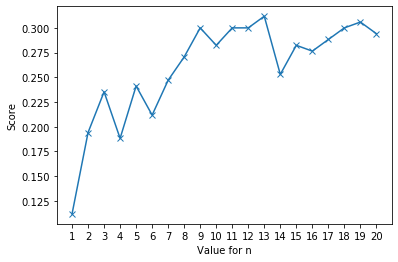

0.31176470588235294

In [37]:
# knn_10.fit(generated_features, Y_train)
# y_pred_knn_10 = knn_10.predict(X_train)
# y_pred_knn_10_test = knn_10.predict(X_test)
scores = []
for i in range(1, len(entropy_with_index)):
    columns = [i[1] for i in entropy_with_index[0:i]]
    knn_10.fit(X_train_interaction_pair[columns], y_train)
    y_pred = knn_10.predict(X_test_intraction_pair[columns])
    score = precision_score(y_pred, y_test)
    scores.append(score)
import matplotlib.pyplot as plt
    
range_n = range(1, len(entropy_with_index))    
op = plt.plot(range_n, scores)
plt.setp(op,'marker', 'x')
plt.xlabel("Value for n")
plt.xticks(range_n)
plt.ylabel("Score")
plt.show()
max(scores)

In [38]:
score_test_knn_10

0.5108695652173914

In [33]:
scores

[0.06470588235294118,
 0.07058823529411765,
 0.25882352941176473,
 0.22941176470588234,
 0.2411764705882353,
 0.25882352941176473,
 0.27647058823529413,
 0.25882352941176473,
 0.27058823529411763,
 0.27058823529411763,
 0.28823529411764703,
 0.3058823529411765,
 0.3,
 0.29411764705882354,
 0.2823529411764706,
 0.3,
 0.2647058823529412,
 0.28823529411764703,
 0.3058823529411765,
 0.27647058823529413]